# Data definition & preparation

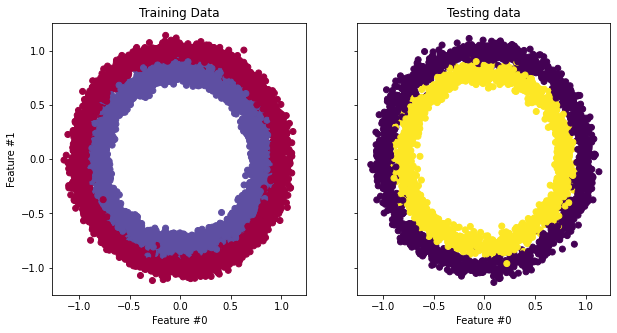

In [386]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create a dataset with 10,000 samples.
X, y = make_circles(n_samples = 10000,
                    noise= 0.05, 
                    random_state=26)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

In [387]:
print(X.shape,"\n", X) 

(10000, 2) 
 [[ 0.22073819 -0.96356351]
 [ 0.85618516 -0.39409485]
 [ 0.62780991  0.80606666]
 ...
 [ 0.76899099 -0.33128526]
 [ 0.30147304  0.72290269]
 [ 1.00378574 -0.14098938]]


In [389]:
import warnings 
warnings.filterwarnings("ignore")

!pip install torch -q

import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader 

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self): 
        return self.len
    
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


# Neural netowrk implementation & model training

In [390]:
import torch 
from torch import nn
from torch import optim

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): 
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim) 
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x
        
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [391]:
learning_rate = 0.1
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [392]:
num_epochs = 100
loss_values = []
# since we're not training, we don't need to calculate the gradients for our outputs
for epoch in range(num_epochs):
    for X, y in train_dataloader: 
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


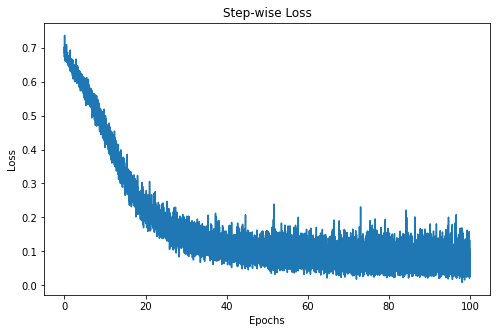

In [393]:
step = np.linspace(0, 100, 10500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Predictions and model evaluation

In [394]:
import itertools

correct = 0
total = 0
y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted) 
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

Accuracy of the network on the 3300 test instances: 97%


In [395]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)
print(classification_report(y_test, y_pred))

[[1593   42]
 [  25 1640]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1635
         1.0       0.98      0.98      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



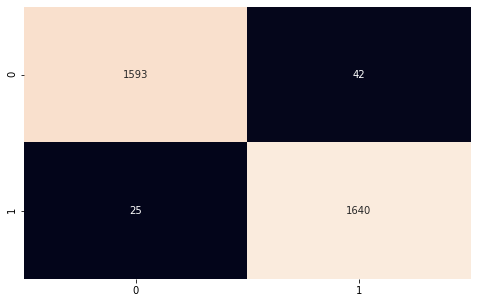

In [400]:
import seaborn as sns

plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
plt.show()